In [1]:
#basics
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import glob
import datetime
from matplotlib import dates as mdates
import matplotlib.pyplot as plt

from util import smooth_data
from caldordata import merged_gdf, monthlySD, cap23

from dirs import projdir, datadir, asodatadir
# from caldordata import watershed, caldor, sfa, usa, caldormeta, cdec, wlabels2, usgs_loc, tahoe, srtmlocal
# from caldordata import modis_SCF, mtbs_rdnbr

from caldordata import stylesheet
plt.style.use(stylesheet)

/Users/cowherd/Documents/caldor-snow/scripts/caldordata.py:33: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  caldormeta = gpd.GeoDataFrame(caldormeta, crs = 'EPSG:4326') ## see if this works.
Warning 1: +init=epsg:XXXX syntax is deprecated. It might return a CRS with a non-EPSG compliant axis order.


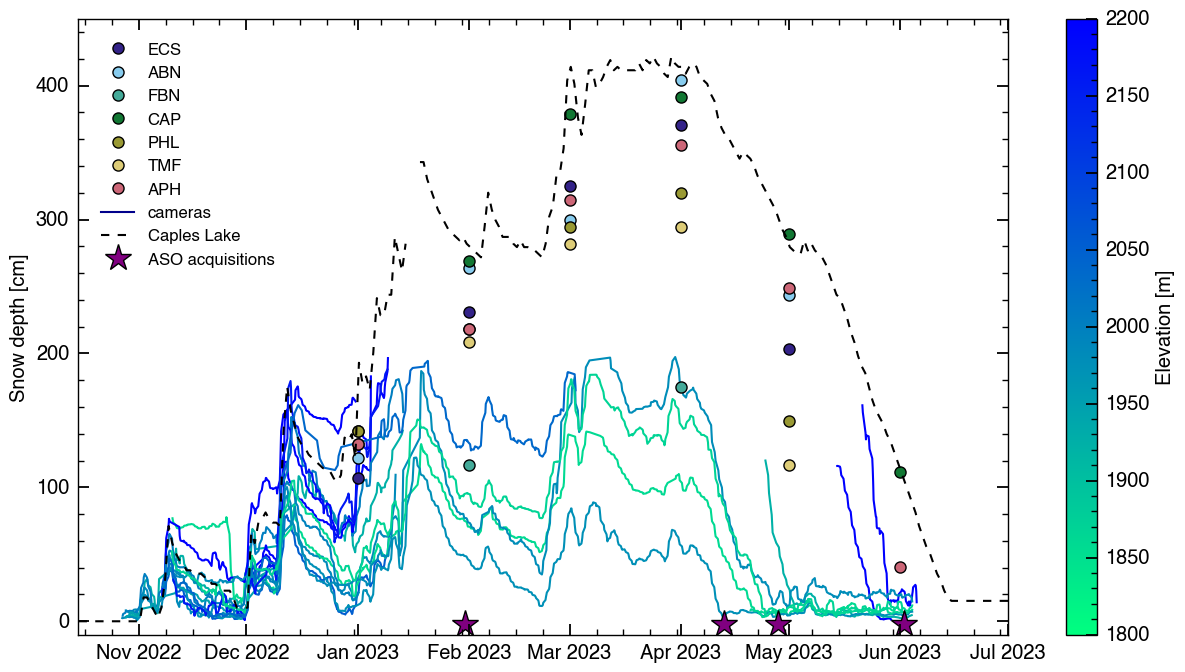

In [2]:
## processed camera data ## 
fnsp = glob.glob(f'{datadir}/processed/*_processsed.csv')

IN_TO_CM = 2.54
sc_colors = ["#332288","#88CCEE","#44AA99","#117733","#999933","#DDCC77","#CC6677","#882255"]
cmap = plt.cm.winter_r  
norm = plt.Normalize(vmin=1800, vmax=2200)
skip = ['286', '580']
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
for fn in fnsp:
    name=fn.split('_')[-2]
    if name not in skip:
        data = pd.read_csv(fn, parse_dates=True, index_col=0)
        cam = fn.split('/')[-1].split('_')[0:3]
        elev = merged_gdf[merged_gdf.camera_serial == int(cam[2])].elev.values[0]
        smoothed = smooth_data(data['snowdepth_ft'], window_length=12, polyorder=3)
        '''camera-specific things'''
        if name == '186':
            smoothed[345:-1] = np.nan
        if name == '307':
            smoothed[152:154] = [6, np.nan]
        if name == '249':
            smoothed[206:212] = np.nan
        if name == '523':
            smoothed[246:248] = np.nan
        if name == '257':
            smoothed[-3:] = np.nan

        ax.plot(data.index, smoothed * 12 * IN_TO_CM, color=cmap(norm(elev)), label = name)

for i,key in enumerate(monthlySD.keys()):
    mydata = monthlySD[key]
    mydata23 = mydata[mydata.index.year >=2023]
    ax.plot(mydata23.index, mydata23['SNOWDEPTHIN'] * IN_TO_CM, label=key, marker = 'o', linestyle = 'None', color = sc_colors[i])
# ax.plot(cap23.datetime, cap23.SNOWDEPTH * IN_TO_CM , 'r:', linewidth = 2, label = 'Caples')

ax.plot([0,0],[0,10], color = 'darkblue', label = 'cameras')
l1 = 17

ax.plot(pd.DatetimeIndex(cap23.datetime), cap23.SNOWDEPTH * 2.54, linestyle = '--', label = 'Caples Lake')

aso_dates = [datetime.datetime(2023,1,31), datetime.datetime(2023,4,13), datetime.datetime(2023,4,28), datetime.datetime(2023,6,2)]

ax.plot(aso_dates, [-2,-2,-2,-2], '*', color = 'purple', label = 'ASO acquisitions', markersize = 20)


handles, labels = ax.get_legend_handles_labels()
# ax.legend()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Elevation [m]')
ax.set_ylabel('Snow depth [cm]')
ax.set_ylim((-10,450))
ax.set_xlim ((datetime.datetime(2022, 10, 15), datetime.datetime(2023, 7, 1)))

ax.legend(handles[l1:], labels[l1:], loc = 'upper left')

months = mdates.MonthLocator()
ax.xaxis.set_major_locator(months)

# Format the x tick labels as Month, Year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.savefig('../figures/time-series.jpg', dpi = 800, bbox_inches = 'tight')
plt.show()

In [3]:
from caldordata import category_masks, categories, sfa_watershed, caldor
dates = ['2023Jan31', '2023Apr13', '2023Apr28','2023Jun02'] # , '2024Feb11-12']

inside_values = []
outside_values = []
categ_vals = {}
regrowth_values = []
unburned_values = []
low_values = []
moderate_values = []
high_values = []
for date in dates:
    asofn = glob.glob(f'{asodatadir}/*American*/*{date}*snowdepth_50m.tif')[0]
    ds = xr.open_rasterio(asofn)
    ds = ds.rio.reproject('epsg:4326')
    ds = ds.rio.clip(sfa_watershed.geometry)
    inside = ds.rio.clip(caldor.geometry, invert=False)
    outside = ds.rio.clip(caldor.geometry, invert=True)
    inside = inside.where(inside >=0)
    outside = outside.where(outside >=0)
    
    
    in_cat = inside.where(category_masks['Regrowth']).sel(band=1).band_data.values.flatten() * 100
    regrowth_values.append(in_cat[~np.isnan(in_cat)])
    in_cat = inside.where(category_masks['Unburned']).sel(band=1).band_data.values.flatten() * 100
    unburned_values.append(in_cat[~np.isnan(in_cat)])
    in_cat = inside.where(category_masks['Low']).sel(band=1).band_data.values.flatten() * 100
    low_values.append(in_cat[~np.isnan(in_cat)])
    in_cat = inside.where(category_masks['Moderate']).sel(band=1).band_data.values.flatten() * 100
    moderate_values.append(in_cat[~np.isnan(in_cat)])
    in_cat = inside.where(category_masks['High']).sel(band=1).band_data.values.flatten() * 100
    high_values.append(in_cat[~np.isnan(in_cat)])
         
    categ_vals[date] = {}
    for cat in categories:
         in_cat = inside.where(category_masks[cat]).sel(band=1).band_data.values.flatten() * 100
         categ_vals[date][cat] = in_cat[~np.isnan(in_cat)]
    ins = inside.values.flatten() * 100
    out = outside.values.flatten() * 100
    
    inside_values.append(ins[~np.isnan(ins)])
    outside_values.append(out[~np.isnan(out)])

/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_36502/102000944.py:14: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(asofn)
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_36502/102000944.py:14: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(asofn)
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_36502/102000944.py:14: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio(asofn)
/var/folders/vx/vw0r7k2s5wj9x5l849ft95ldgqgh30/T/ipykernel_36502/102000944.py:14: 

In [4]:
in_cat

array([], dtype=float32)

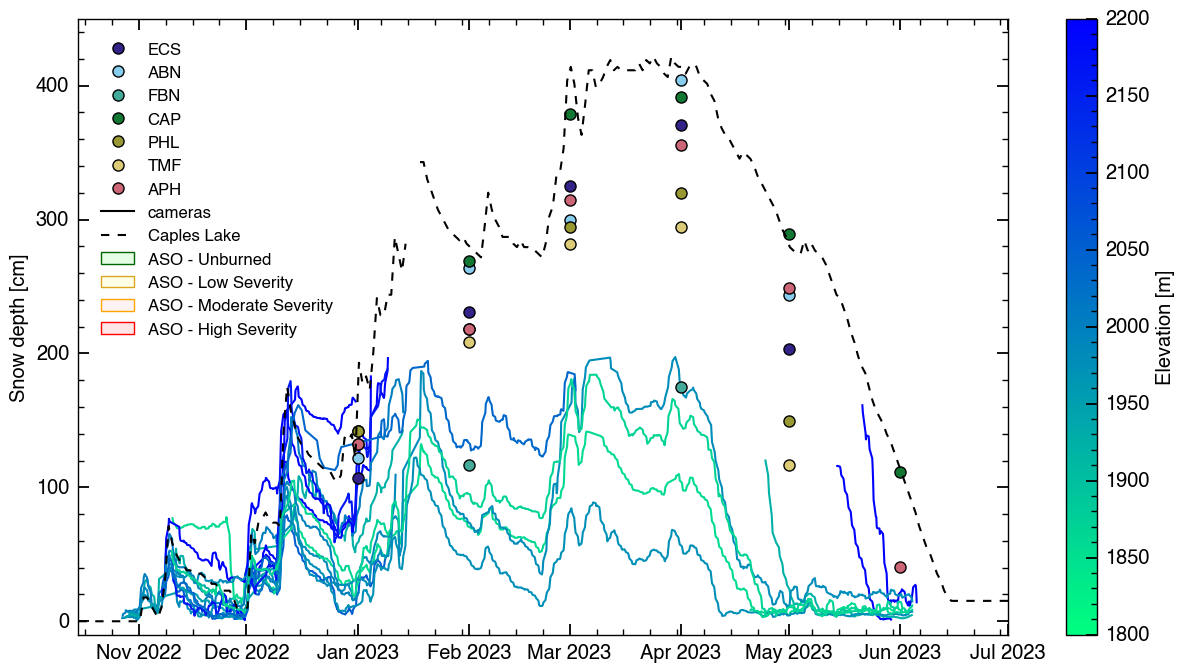

In [5]:
IN_TO_CM = 2.54
dates_dt = [datetime.datetime(2023,1,31), datetime.datetime(2023,4,13), datetime.datetime(2023,4,28), datetime.datetime(2023,6,2)]
dates_num = mdates.date2num(dates_dt)
sc_colors = ["#332288","#88CCEE","#44AA99","#117733","#999933","#DDCC77","#CC6677","#882255"]
cameradates = []
cameraseries = []
cmap = plt.cm.winter_r  
norm = plt.Normalize(vmin=1800, vmax=2200)
skip = ['286', '580']
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
for fn in fnsp:
    name=fn.split('_')[-2]
    if name not in skip:
        data = pd.read_csv(fn, parse_dates=True, index_col=0)
        cam = fn.split('/')[-1].split('_')[0:3]
        elev = merged_gdf[merged_gdf.camera_serial == int(cam[2])].elev.values[0]
        smoothed = smooth_data(data['snowdepth_ft'], window_length=12, polyorder=3)
        '''camera-specific things'''
        if name == '186':
            smoothed[345:-1] = np.nan
        if name == '307':
            smoothed[152:154] = [6, np.nan]
        if name == '249':
            smoothed[206:212] = np.nan
        if name == '523':
            smoothed[246:248] = np.nan
        if name == '257':
            smoothed[-3:] = np.nan

        ax.plot(data.index, smoothed * 12 * IN_TO_CM, color=cmap(norm(elev)), label = name)
        
        cameradates.append(data.index)
        cameraseries.append(smoothed * 12 * IN_TO_CM)
        

for i,key in enumerate(monthlySD.keys()):
    mydata = monthlySD[key]
    mydata23 = mydata[mydata.index.year >=2023]
    ax.plot(mydata23.index, mydata23['SNOWDEPTHIN'] * IN_TO_CM, label=key, marker = 'o', linestyle = 'None', color = sc_colors[i])
# ax.plot(cap23.datetime, cap23.SNOWDEPTH * IN_TO_CM , 'r:', linewidth = 2, label = 'Caples')

ax.plot([0,0],[0,10], color = 'black', label = 'cameras')
l1 = 17

ax.plot(pd.DatetimeIndex(cap23.datetime), cap23.SNOWDEPTH * 2.54, linestyle = '--', label = 'Caples Lake')

handles, labels = ax.get_legend_handles_labels()
# ax.legend()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Elevation [m]')
ax.set_ylabel('Snow depth [cm]')
ax.set_ylim((-10,450))
ax.set_xlim ((datetime.datetime(2022, 10, 15), datetime.datetime(2023, 7, 1)))


# bp1 = ax.boxplot(inside_values, positions=dates_num, widths=3, showfliers=False, patch_artist=True)
#bp2 = ax.boxplot(outside_values, positions=dates_num + 7, widths=2, showfliers=False, patch_artist=True)

bp_u = ax.boxplot(unburned_values, positions=dates_num-3, widths=2, showfliers=False, patch_artist=True)
bp_l = ax.boxplot(low_values, positions=dates_num, widths=2, showfliers=False, patch_artist=True)
bp_m = ax.boxplot(moderate_values, positions=dates_num + 3, widths=2, showfliers=False, patch_artist=True)
bp_h = ax.boxplot(high_values, positions=dates_num + 6, widths=2, showfliers=False, patch_artist=True)


for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    # plt.setp(bp1[element], color='red')
    plt.setp(bp_u[element], color='darkgreen')
    plt.setp(bp_l[element], color='goldenrod')
    plt.setp(bp_m[element], color='orange')
    plt.setp(bp_h[element], color='red')
    
for patch in bp_u['boxes']:
    patch.set_facecolor((0, 1, 0 , 0.1)) 

for patch in bp_l['boxes']:
    patch.set_facecolor((1, 1, 0, 0.1)) 

for patch in bp_m['boxes']:
    patch.set_facecolor((1, 0.5, 0.5, 0.1))  

for patch in bp_h['boxes']:
    patch.set_facecolor((1, 0, 0, 0.1))  

handles.append(bp_u["boxes"][0])
handles.append(bp_l["boxes"][0])
handles.append(bp_m["boxes"][0])
handles.append(bp_h["boxes"][0])

labels.append("ASO - Unburned")
labels.append("ASO - Low Severity")
labels.append("ASO - Moderate Severity")
labels.append("ASO - High Severity")


ax.legend(handles[l1:], labels[l1:], loc = 'upper left')

months = mdates.MonthLocator()
ax.xaxis.set_major_locator(months)

# Format the x tick labels as Month, Year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))


plt.show()